# Calculate Stark map for triplet helium

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from starkhelium import *
from tqdm import trange, tqdm
from scipy.constants import h, hbar, c, alpha, m_e, e, epsilon_0, atomic_mass, pi, physical_constants
a_0 = physical_constants['Bohr radius'][0]
En_h = alpha**2.0 * m_e * c**2.0;
scl = c*10**-9 * En_h /(h * c);

In [2]:
# User variables
  # Whether to import and save the Stark interaction matrix
IMPORT_MAT_S, CALC_MAT_S, SAVE_MAT_S = False, True, True
  # Whether to import and save the Diamagnetic interaction matrix
IMPORT_MAT_D, CALC_MAT_D, SAVE_MAT_D = False, False, False
  # Whether to save the eigenvalues and eigenvectors
SAVE_EIG_VALS = True
SAVE_EIG_VECS = False

In [3]:
# Helper functions
def getDataDir():
    # Create data directoy if it doesn't exist
    directory = os.path.join(".", "data")
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory
def getImagesDir():
    # Create data directoy if it doesn't exist
    directory = os.path.join(".", "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

def getFilenameInt(name, nmin, nmax, step_params):
    return name + "IntMatrix_n_" + str(nmin) + "-" + str(nmax) + \
    "_step_" + str(step_params[0]).replace('.', '-') + "_" + str(step_params[1]).replace('.', '-') + \
    "_" + str(step_params[2]).replace('.', '-')
    
def getFilenameStarkMap(nmin, nmax, step_params, field, B_z):
    return "StarkMapData_n_" + str(nmin) + "-" + str(nmax) + \
    "_step_" + str(step_params[0]).replace('.', '-') + "_" + str(step_params[1]).replace('.', '-') + \
    "_" + str(step_params[2]).replace('.', '-') + \
    "_E_" + str(np.min(field)).replace('.', '-') + "_" + str(np.max(field)).replace('.', '-') + "_" + str(len(field)) + \
    "_B_" + str(B_z*1E3).replace('.', '-') + '.npy'

def saveIntMat(mat_I, name, nmin, nmax, step_params, extra=''):
    # Create fileaname for interaction map
    filename = getFilenameInt(name, nmin, nmax, step_params) + extra
    # Get data directoy, create it if it doesn't exist
    directory = getDataDir()
    # Save interaction matrix to file
    fileout = os.path.join(directory, filename)
    np.save(fileout, mat_I)
    
def importIntMat(name, nmin, nmax, step_params, extra=''):
    filename = name + "IntMatrix_n_" + str(nmin) + "-" + str(nmax) + extra + ".npy"
    directory = getDataDir()
    filein = os.path.join(directory, filename)
    try:
        return np.load(filein)
    except:
        raise

In [4]:
for qd_error in [-5,-4,-3]:
    # quantum numbers
    nmin = 69
    nmax = 74
    S = 1
    n_vals, L_vals, m_vals = get_nlm_vals(nmin, nmax)
    J_vals = get_J_vals(S, L_vals, 1)
    # quantum defects
    neff = n_vals - get_qd(S, n_vals, L_vals, J_vals) + (L_vals==0)*10**qd_error
    # energy levels
    En = W_n(S, n_vals, L_vals, J_vals)
    #En = En_0(neff)
    # field orientation
    field_orientation = 'crossed'
    # field-free Hamiltonian
    H_0 = np.diag(En)
    # Numerov step size
    step_low = 0.005
    step_high = 0.005
    interp_type = 'sigmoid'
    sigmoid_width = 10.0
    sigmoid_pos = 0.5
    round_step = 4
    useAutoStep = False
    useDict = False
    interp_params = [sigmoid_width, sigmoid_pos, round_step]
    step_params = [step_low, step_high, interp_type, interp_params]

    if IMPORT_MAT_S: mat_S = importIntMat('Stark', nmin, nmax, step_params, extra='_-'+str(abs(qd_error)))
    elif CALC_MAT_S: 
        mat_S = stark_matrix(n_vals, neff, L_vals, m_vals, field_orientation, 
                             step_params=step_params, useAutoStep=useAutoStep, useDict=useDict)
        if SAVE_MAT_S: 
            saveIntMat(mat_S, 'Stark', nmin, nmax, step_params, extra='_-'+str(abs(qd_error)))
            del mat_S

    if IMPORT_MAT_D: mat_D = importIntMat('Diamagnetic', nmin, nmax, step_params)
    elif CALC_MAT_D: 
        mat_D = diamagnetic_matrix(n_vals, neff, L_vals, m_vals, 
                                   step_params=step_params, useAutoStep=useAutoStep, useDict=useDict)
        if SAVE_MAT_D: 
            saveIntMat(mat_D, 'Diamagnetic', nmin, nmax, step_params)
            del mat_D

Calculating Stark terms: 100%|█████████| 30691/30691 [3:12:51<00:00,  2.65it/s]


In [35]:
# specify the electric field
field = np.linspace(0.845, 0.849, 5) # V /cm
field_au = field * 100 / (En_h_He/(e*a_0_He)) 
# specify the magnetic field (in Telsa)
B_z = 1.6154E-3
# (in atomic units)
B_z_au = B_z / (hbar/(e*a_0_He**2))
# Zeeman interaction Hamiltonian
H_Z = np.diag(E_zeeman(m_vals, B_z_au))
# Diamagnetic interaction Hamiltonian
if IMPORT_MAT_D or CALC_MAT_D:
    H_D = mat_D * (B_z_au**2)/8
else:
    H_D = 0

# diagonalise for each field
if SAVE_EIG_VECS:
    eig_vals_vecs = stark_map_vec(H_0, mat_S, field_au, H_Z=H_Z, H_D=H_D)
else:
    eig_vals_vecs = stark_map(H_0, mat_S, field_au, H_Z=H_Z, H_D=H_D)

if SAVE_EIG_VALS or SAVE_EIG_VECS:
    # Save Stark map to file
    filename = getFilenameStarkMap(nmin, nmax, step_params, field, B_z)
    fileout = os.path.join(getDataDir(), filename)
    np.save(fileout, eig_vals_vecs)


diagonalise Hamiltonian: 100%|██████████████████| 5/5 [09:11<00:00, 110.90s/it]


In [6]:
# quantum numbers
nmin = 72
nmax = 73
S = 1
n_vals, L_vals, m_vals = get_nlm_vals(nmin, nmax)
J_vals = get_J_vals(S, L_vals, 1)
# quantum defects
neff = n_vals - get_qd(S, n_vals, L_vals, J_vals) + (L_vals==0)*10**qd_error
# energy levels
En = W_n(S, n_vals, L_vals, J_vals)
#En = En_0(neff)
# field orientation
field_orientation = 'crossed'
# field-free Hamiltonian
H_0 = np.diag(En)

# Numerov step size
step_low = 0.005
step_high = 0.005
interp_type = 'sigmoid'
sigmoid_width = 10.0
sigmoid_pos = 0.5
round_step = 4
useAutoStep = False
interp_params = [sigmoid_width, sigmoid_pos, round_step]
step_params = [step_low, step_high, interp_type, interp_params]

mat_S_0 = importIntMat('Stark', nmin, nmax, step_params, extra='_-'+str(0))
mat_S_1 = importIntMat('Stark', nmin, nmax, step_params, extra='_-'+str(1))
mat_S_2 = importIntMat('Stark', nmin, nmax, step_params, extra='_-'+str(2))
mat_S_3 = importIntMat('Stark', nmin, nmax, step_params, extra='_-'+str(3))
mat_S_4 = importIntMat('Stark', nmin, nmax, step_params, extra='_-'+str(4))
mat_S_5 = importIntMat('Stark', nmin, nmax, step_params, extra='_-'+str(5))

In [7]:
# specify the electric field
field = np.linspace(0.845, 0.849, 5) # V /cm
field_au = field * 100 / (En_h_He/(e*a_0_He)) 
# specify the magnetic field (in Telsa)
B_z = 1.6154E-3
# (in atomic units)
B_z_au = B_z / (hbar/(e*a_0_He**2))
# Zeeman interaction Hamiltonian
H_Z = np.diag(E_zeeman(m_vals, B_z_au))

In [8]:
eig_vals_vecs_0 = stark_map(H_0, mat_S_0, field_au, H_Z=H_Z)
eig_vals_vecs_1 = stark_map(H_0, mat_S_1, field_au, H_Z=H_Z)
eig_vals_vecs_2 = stark_map(H_0, mat_S_2, field_au, H_Z=H_Z)
eig_vals_vecs_3 = stark_map(H_0, mat_S_3, field_au, H_Z=H_Z)
eig_vals_vecs_4 = stark_map(H_0, mat_S_4, field_au, H_Z=H_Z)
eig_vals_vecs_5 = stark_map(H_0, mat_S_5, field_au, H_Z=H_Z)

diagonalise Hamiltonian: 100%|██████████████████| 5/5 [08:57<00:00, 107.50s/it]


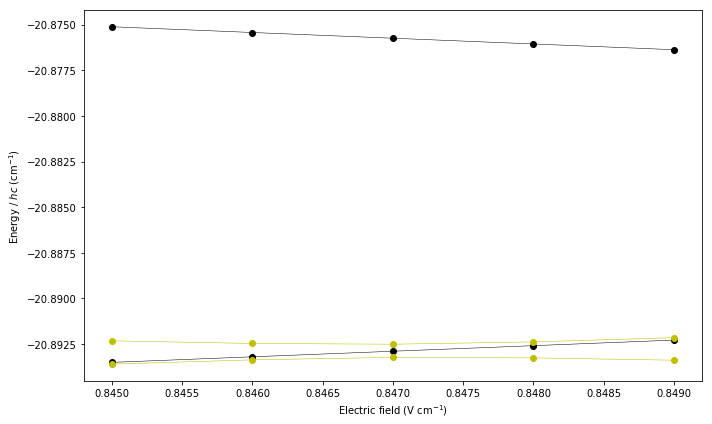

In [10]:
state_73s_72_73 = 72**2

# Plot Stark map
plt.subplots(figsize=(10, 6))

plt.plot(field, 0.01*eig_vals_vecs_0[:, state_73s_72_73] * En_h /(h * c), c='k', ls='-', marker='o', lw=0.5)
plt.plot(field, 0.01*eig_vals_vecs_0[:, state_73s_72_73-1] * En_h /(h * c), c='k', ls='-', marker='o', lw=0.5)

#plt.plot(field, 0.01*eig_vals_vecs_1[:, state_73s_72_73] * En_h /(h * c), c='r', ls='-', marker='o', lw=0.5)
#plt.plot(field, 0.01*eig_vals_vecs_1[:, state_73s_72_73-1] * En_h /(h * c), c='r', ls='-', marker='o', lw=0.5)

#plt.plot(field, 0.01*eig_vals_vecs_2[:, state_73s_72_73] * En_h /(h * c), c='g', ls='-', marker='o', lw=0.5)
#plt.plot(field, 0.01*eig_vals_vecs_2[:, state_73s_72_73-1] * En_h /(h * c), c='g', ls='-', marker='o', lw=0.5)

#plt.plot(field, 0.01*eig_vals_vecs_3[:, state_73s_72_73] * En_h /(h * c), c='b', ls='-', marker='o', lw=0.5)
#plt.plot(field, 0.01*eig_vals_vecs_3[:, state_73s_72_73-1] * En_h /(h * c), c='b', ls='-', marker='o', lw=0.5)

#plt.plot(field, 0.01*eig_vals_vecs_4[:, state_73s_72_73] * En_h /(h * c), c='c', ls='-', marker='o', lw=0.5)
#plt.plot(field, 0.01*eig_vals_vecs_4[:, state_73s_72_73-1] * En_h /(h * c), c='c', ls='-', marker='o', lw=0.5)

plt.plot(field, 0.01*eig_vals_vecs_5[:, state_73s_72_73] * En_h /(h * c), c='y', ls='-', marker='o', lw=0.5)
plt.plot(field, 0.01*eig_vals_vecs_5[:, state_73s_72_73-1] * En_h /(h * c), c='y', ls='-', marker='o', lw=0.5)

#for s0 in trange(np.shape(eig_vals_vecs)[1], desc='Plotting'):
#    plt.plot(field, 0.01*eig_vals_vecs[:, s0] * En_h /(h * c), c='k', ls='-', marker='', lw=0.5)

# format
#plt.ylim(-36.25, -36.22)
#plt.xlim(0, 0.02)
plt.xlabel('Electric field (V cm$^{-1}$)')
plt.ylabel('Energy / $h c$ (cm$^{-1}$)')
plt.tight_layout()